<a href="https://colab.research.google.com/github/AlphaKermit-999/AI-Topics-learnings/blob/main/Advanced_AI/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [237]:
import networkx as nx

In [238]:
num_of_nodes = 10
probability = 0.5
graph = nx.erdos_renyi_graph(num_of_nodes, probability, seed=5) # generating random graph


In [239]:
graph.number_of_edges()

20

In [240]:
graph.number_of_nodes()

10

In [241]:
# G = nx.DiGraph() # undirected graph
# G.add_edge("A", "B", weight=5)
# G.add_edge("A", "C", weight=2)
# G.add_edge("B", "C", weight=2)
# G.add_edge("D", "C", weight=5)

# G.number_of_edges()
# G.number_of_nodes()

In [242]:
import numpy as np
node_features = np.random.rand(num_of_nodes, num_of_nodes)  # 10 features per node
labels = np.random.randint(0, 2, size=num_of_nodes)  # binary class

In [243]:
np.random.randint(0, 2, size=10)

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 0])

In [244]:
np.random.rand(num_of_nodes, num_of_nodes).shape

(10, 10)

Adjacent Matrix

In [245]:
adj_matrix = nx.adjacency_matrix(graph).todense()
adj_matrix

array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 1, 1, 0, 1, 1],
       [0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 1, 1, 0, 0, 1, 1],
       [1, 0, 0, 1, 0, 0, 0, 1, 0, 1],
       [0, 1, 1, 1, 0, 0, 1, 1, 1, 0]])

In [246]:
adj_matrix = adj_matrix + np.eye(num_of_nodes)

In [247]:
# degrees
degree = np.array(adj_matrix.sum(axis=1))
degree_inv_sqrt = np.power(degree, -0.5)
degree_inv_sqrt_mat = np.diag(degree_inv_sqrt)
degree_inv_sqrt_mat.shape

(10, 10)

In [248]:
adj_matrix_normalized = degree_inv_sqrt_mat@adj_matrix@degree_inv_sqrt_mat

In [249]:
adj_matrix_normalized

array([[0.33333333, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.21821789, 0.25819889, 0.        ],
       [0.        , 0.2       , 0.        , 0.        , 0.2236068 ,
        0.2236068 , 0.2236068 , 0.        , 0.        , 0.16903085],
       [0.        , 0.        , 0.2       , 0.18257419, 0.2236068 ,
        0.        , 0.        , 0.16903085, 0.        , 0.16903085],
       [0.        , 0.        , 0.18257419, 0.16666667, 0.        ,
        0.20412415, 0.20412415, 0.        , 0.18257419, 0.15430335],
       [0.        , 0.2236068 , 0.2236068 , 0.        , 0.25      ,
        0.        , 0.        , 0.18898224, 0.        , 0.        ],
       [0.        , 0.2236068 , 0.        , 0.20412415, 0.        ,
        0.25      , 0.        , 0.18898224, 0.        , 0.        ],
       [0.        , 0.2236068 , 0.        , 0.20412415, 0.        ,
        0.        , 0.25      , 0.        , 0.        , 0.18898224],
       [0.21821789, 0.        , 0.1690308

In [250]:
# train, test = train_test_split(df, test_size=0.2, random_state=5)

In [251]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(range(num_of_nodes), test_size=0.2, random_state=5)

In [252]:
train = np.isin(range(num_of_nodes), train) #boolean array

In [253]:
test = ~train

In [254]:
import tensorflow as tf
node_features = tf.convert_to_tensor(node_features, dtype=tf.float32)
adj_matrix_normalized = tf.convert_to_tensor(adj_matrix_normalized, dtype=tf.float32)
labels = tf.convert_to_tensor(labels, dtype=tf.float32)

# GraphSage --- graph sample and aggregation
Sampling node neighbors
Aggregating node features

Inductive: new/unseen

In [255]:
class GraphSagelayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation=None, **kwargs):
        super(GraphSagelayer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation) # Get activation function from string

    def build(self, input_shape):
      self.weight = self.add_weight(shape=(input_shape[0][-1], self.output_dim),
                                  initializer = "glorot_uniform",
                                  trainable = True)

    def call(self, inputs):
      node_features, adj_matrix = inputs

      aggregated_features = tf.matmul(adj_matrix, node_features)
      output = tf.matmul(aggregated_features, self.weight)

      if self.activation is not None:
        output = self.activation(output)

      return output

In [256]:
def create_graphsage_model(input_dim, hidden_dim, output_dim):
  features_inputs = tf.keras.Input(shape=(input_dim,))
  adjacency_input = tf.keras.Input(shape=(num_of_nodes,))
  h1 = GraphSagelayer(hidden_dim, activation=tf.nn.relu)([features_inputs, adjacency_input])
  h2 = GraphSagelayer(hidden_dim, activation=tf.nn.relu)([h1, adjacency_input])
  h3 = GraphSagelayer(hidden_dim, activation=tf.nn.relu)([h2, adjacency_input])
  logits = GraphSagelayer(1)([h3, adjacency_input]) # Changed output_dim to 1
  model = tf.keras.Model(inputs=[features_inputs, adjacency_input], outputs=logits)

  return model

In [257]:
model = create_graphsage_model(input_dim=num_of_nodes, hidden_dim=16, output_dim=1)

In [258]:
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

In [259]:
# model.fit([node_features,adj_matrix_normalized], labels, epochs=100, batch_size=32, validation_split=0.2)

In [260]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_step_graphsage(node_indices_batch, node_features, adj_matrix_normalised, labels, model, optimizer):
    with tf.GradientTape() as tape:
        # Pass the full graph data to the model
        logits = model([node_features, adj_matrix_normalised], training=True)

        # Select the logits for the nodes in the current batch
        batch_logits = tf.gather(logits, node_indices_batch)

        # Select the corresponding labels for the nodes in the current batch
        batch_labels = tf.gather(labels, node_indices_batch)

        # Calculate the loss for the batch
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(batch_labels, batch_logits)

    # Calculate gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

#Train the model

Subtask:
Use the custom training loop to iterate over the data in batches, updating the model's weights in each step.

Reasoning: Implement the custom training loop by iterating through epochs and batches, calling the defined train_step_graphsage function for each batch.

In [261]:
epochs = 100
batch_size = 8 # Example batch size

# Create a dataset from node indices for batching
dataset = tf.data.Dataset.from_tensor_slices(range(num_of_nodes)).batch(batch_size)

for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0
    for batch_indices in dataset:
        loss = train_step_graphsage(batch_indices, node_features, adj_matrix_normalized, labels, model, optimizer)
        epoch_loss += loss.numpy()
        num_batches += 1

    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

Epoch 1/100, Loss: 0.6545
Epoch 2/100, Loss: 0.6169
Epoch 3/100, Loss: 0.5801
Epoch 4/100, Loss: 0.5400
Epoch 5/100, Loss: 0.5046
Epoch 6/100, Loss: 0.4802
Epoch 7/100, Loss: 0.4682
Epoch 8/100, Loss: 0.4675
Epoch 9/100, Loss: 0.4733
Epoch 10/100, Loss: 0.4801
Epoch 11/100, Loss: 0.4845
Epoch 12/100, Loss: 0.4857
Epoch 13/100, Loss: 0.4847
Epoch 14/100, Loss: 0.4827
Epoch 15/100, Loss: 0.4807
Epoch 16/100, Loss: 0.4791
Epoch 17/100, Loss: 0.4781
Epoch 18/100, Loss: 0.4775
Epoch 19/100, Loss: 0.4772
Epoch 20/100, Loss: 0.4769
Epoch 21/100, Loss: 0.4765
Epoch 22/100, Loss: 0.4761
Epoch 23/100, Loss: 0.4757
Epoch 24/100, Loss: 0.4752
Epoch 25/100, Loss: 0.4749
Epoch 26/100, Loss: 0.4747
Epoch 27/100, Loss: 0.4746
Epoch 28/100, Loss: 0.4746
Epoch 29/100, Loss: 0.4748
Epoch 30/100, Loss: 0.4750
Epoch 31/100, Loss: 0.4752
Epoch 32/100, Loss: 0.4754
Epoch 33/100, Loss: 0.4755
Epoch 34/100, Loss: 0.4756
Epoch 35/100, Loss: 0.4757
Epoch 36/100, Loss: 0.4757
Epoch 37/100, Loss: 0.4757
Epoch 38/1

#Evaluate the model
Subtask:
After training, evaluate the model's performance on the test set.

Reasoning: Evaluate the trained model on the test set by making predictions, applying a threshold to get binary labels, and calculating the accuracy.

In [262]:
# Make predictions on the full graph data
predictions = model([node_features, adj_matrix_normalized], training=False)

# Apply sigmoid to get probabilities
probabilities = tf.sigmoid(predictions)

# Apply a threshold to get binary predictions
predicted_labels = tf.cast(probabilities > 0.5, dtype=tf.float32)

# Select predictions and true labels for the test set
test_predicted_labels = tf.gather(predicted_labels, tf.where(test)[:, 0])
test_true_labels = tf.gather(labels, tf.where(test)[:, 0])

# Calculate accuracy on the test set
accuracy = tf.reduce_mean(tf.cast(tf.equal(test_predicted_labels, test_true_labels), dtype=tf.float32))

# Print the test accuracy
print(f"Test Accuracy: {accuracy.numpy():.4f}")

Test Accuracy: 1.0000


In [263]:
predictions = model([node_features, adj_matrix_normalized], training=False)
pred = tf.argmax(predictions, axis=1).numpy()

In [264]:
pos = nx.spring_layout(graph)
node_colors = ['red' if label==0 else 'blue' for label in labels.numpy()]
pred_colors = ['red' if label==0 else 'blue' for label in pred]

In [265]:
test_true_labels

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>

In [266]:
test_true_labels.numpy()

array([1., 1.], dtype=float32)

In [267]:
node_colors

['blue', 'blue', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue']

In [268]:
pred_colors

['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red']

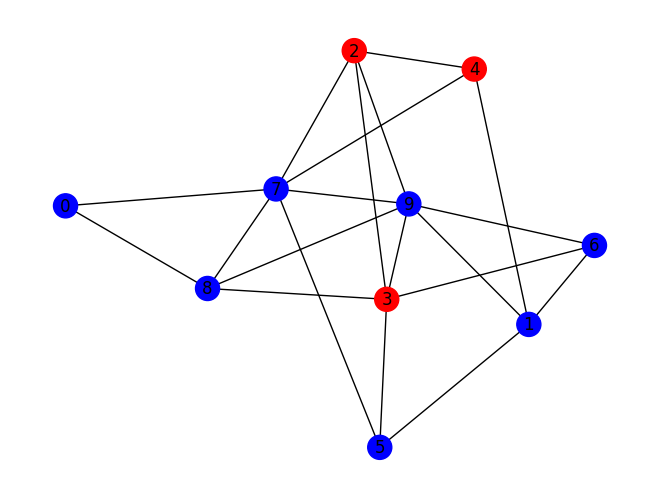

In [269]:
nx.draw(graph, pos, node_color=node_colors, with_labels=True)

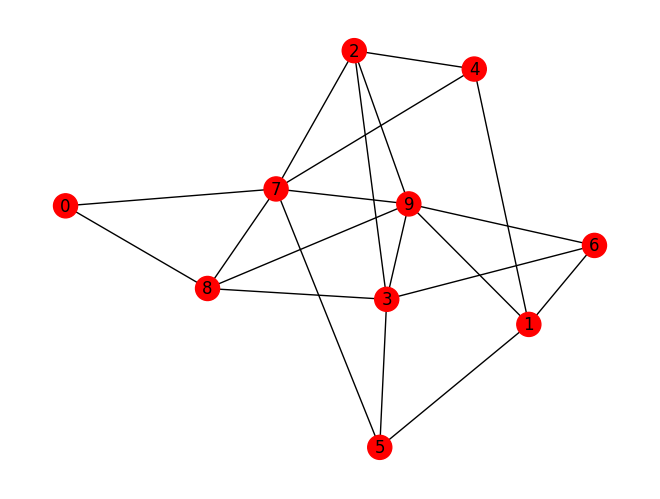

In [270]:
nx.draw(graph, pos, node_color=pred_colors, with_labels=True)